<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Transformations</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import stats

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

numpy     1.18.1
scipy     1.4.1
pandas    1.0.1
autopep8  1.5
watermark 2.0.2
json      2.0.9
Mon Jul 27 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 83a27908ad0b74a39ed3124f4f249172297b5c74


Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

In this notebook we illustrate several of the typical transformations and data manipulations that are common in time series analysis. Let's start by loading the Dow-Jones Industrial Average dataset

Text(0.5, 0, 'Date')

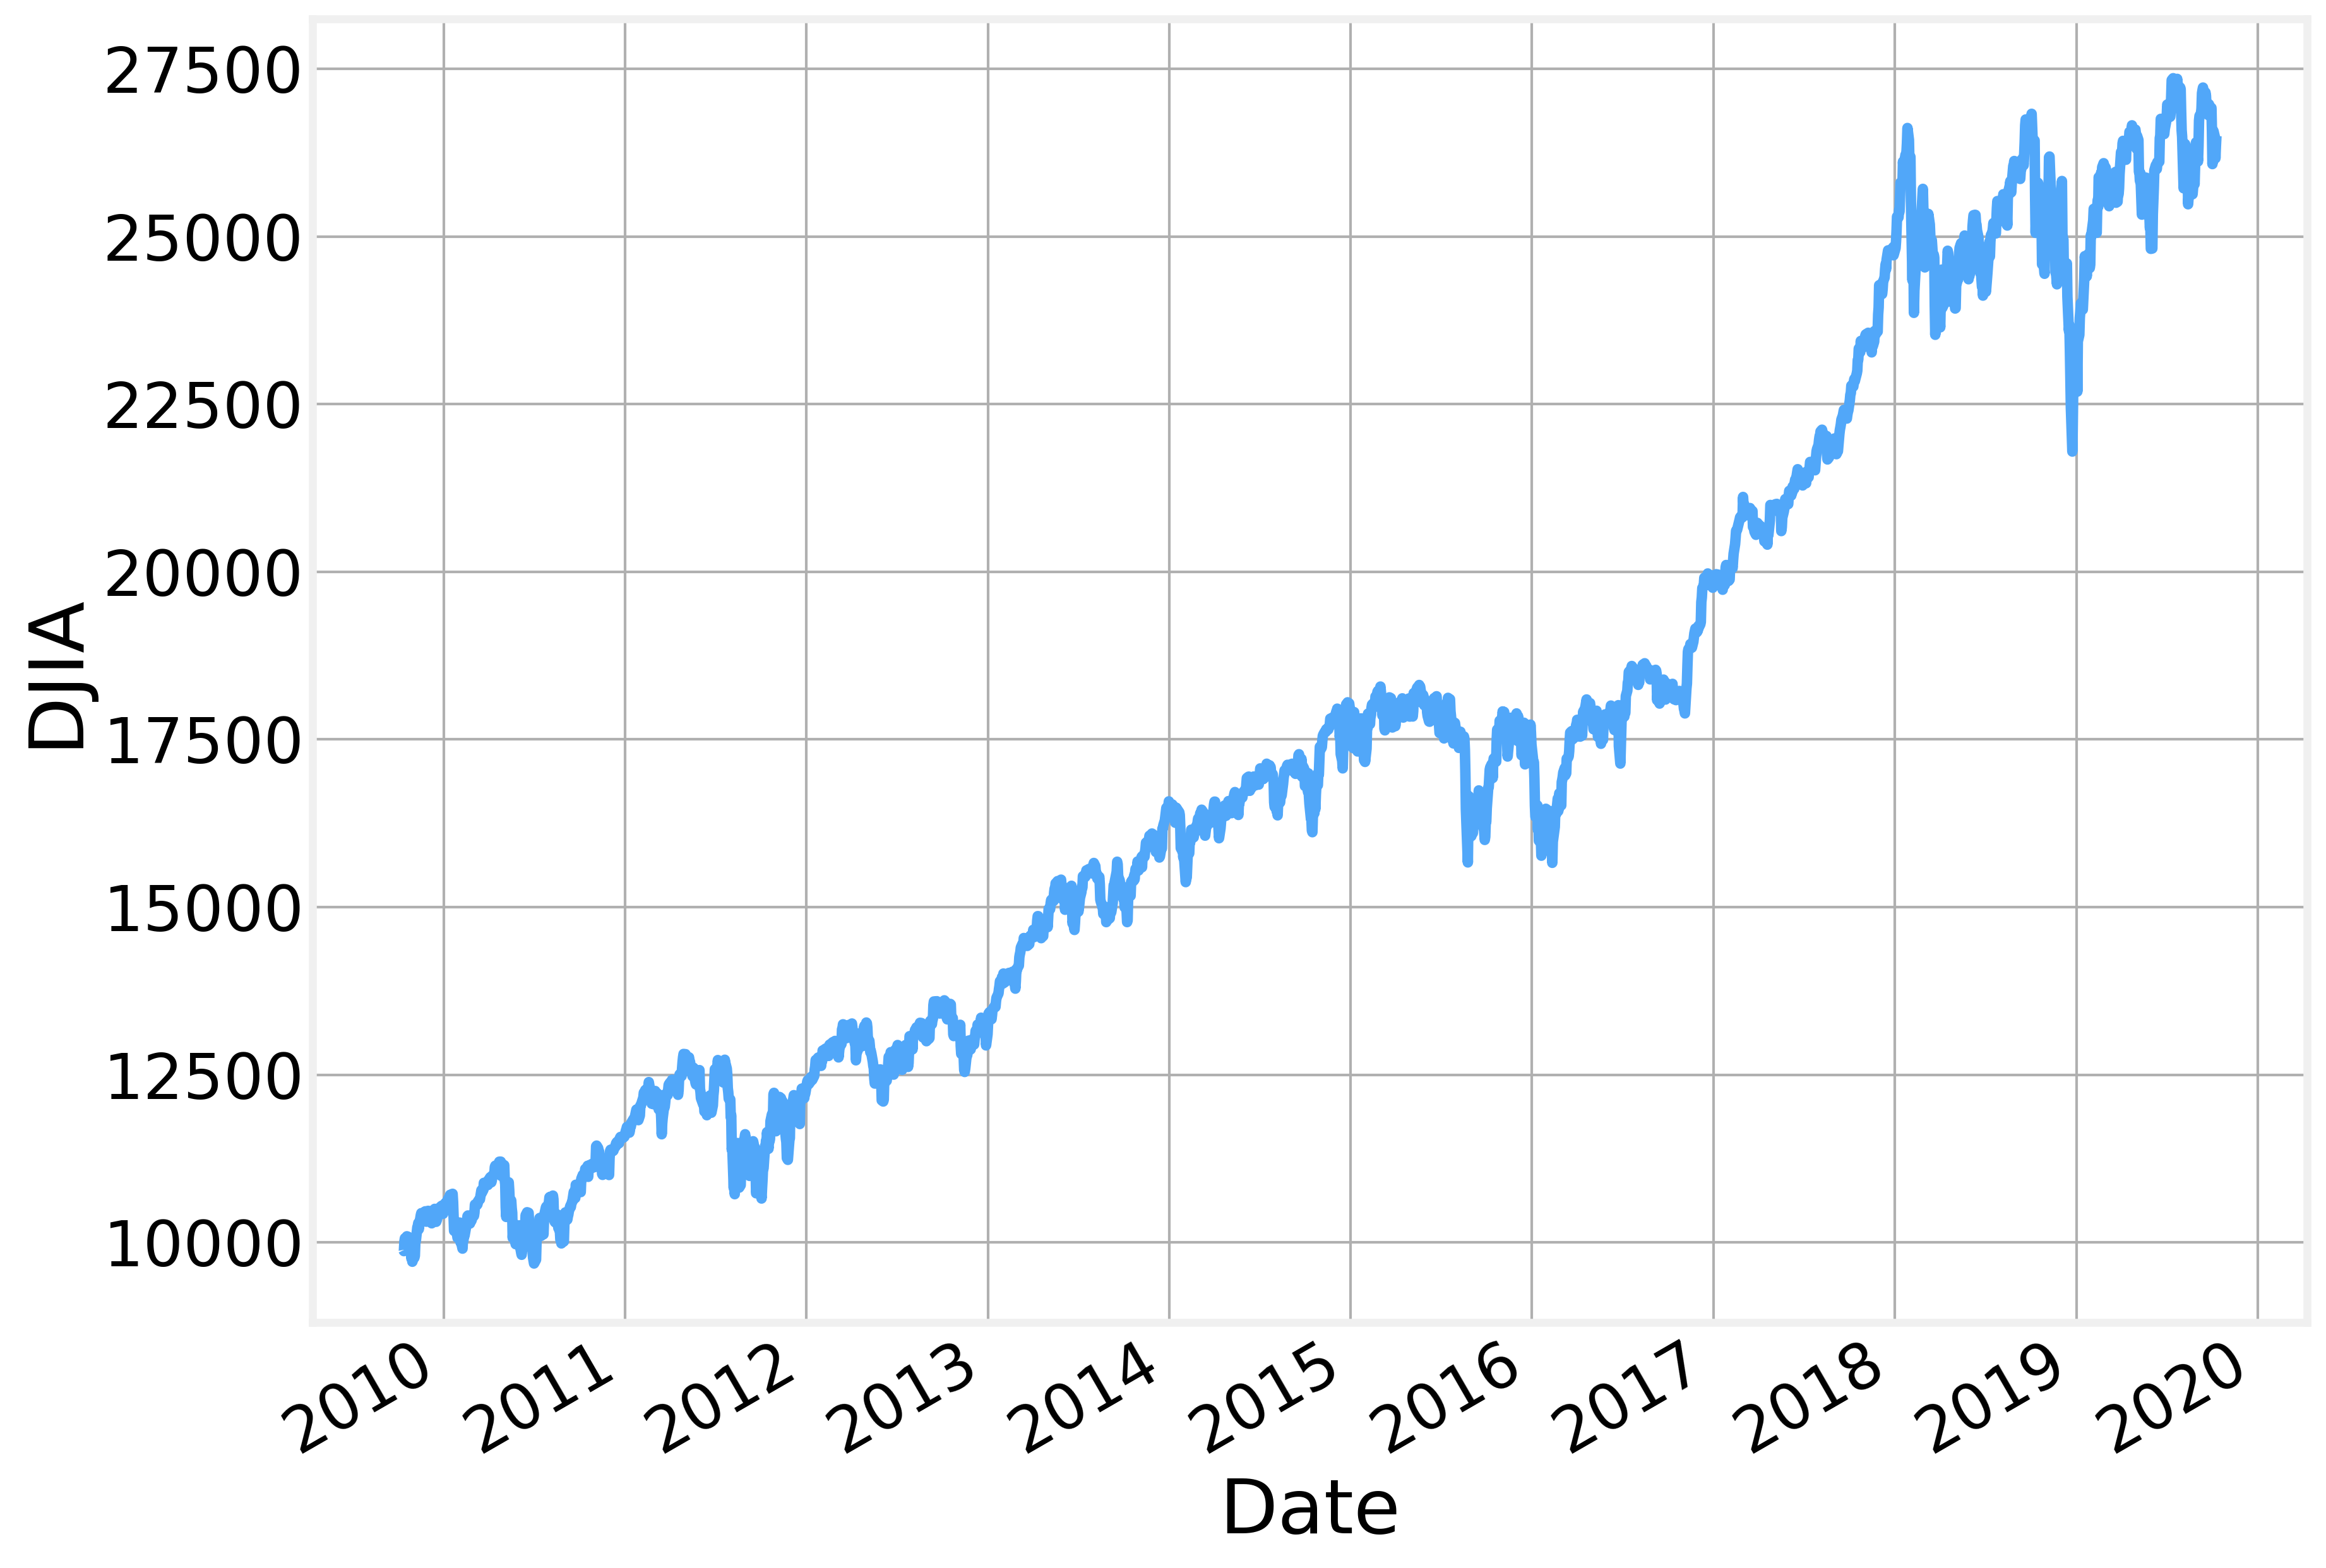

In [4]:
DJIA = pd.read_csv('data/DJIA.csv', parse_dates=['DATE'], na_values='.').dropna()
DJIA.plot(x='DATE', legend=False)
ax = plt.gca()
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

## Differences

One way of removing the trend from a dataset is to differentiate it. Since we are dealing with discretized datasets this is the same as using finite differences.

In [5]:
def differentiate(values, d=1):
    # First value is required so that we can recover the original values with np.cumsum
    x = np.concatenate([[values[0]], values[1:]-values[:-1]])

    if d == 1:
        return x
    else:    
        return difference(x, d - 1)

In [6]:
values = DJIA['DJIA'].values
differences = differentiate(values)

As we can see, the differnce plot is significantly more stationary

Text(0, 0.5, 'Differences')

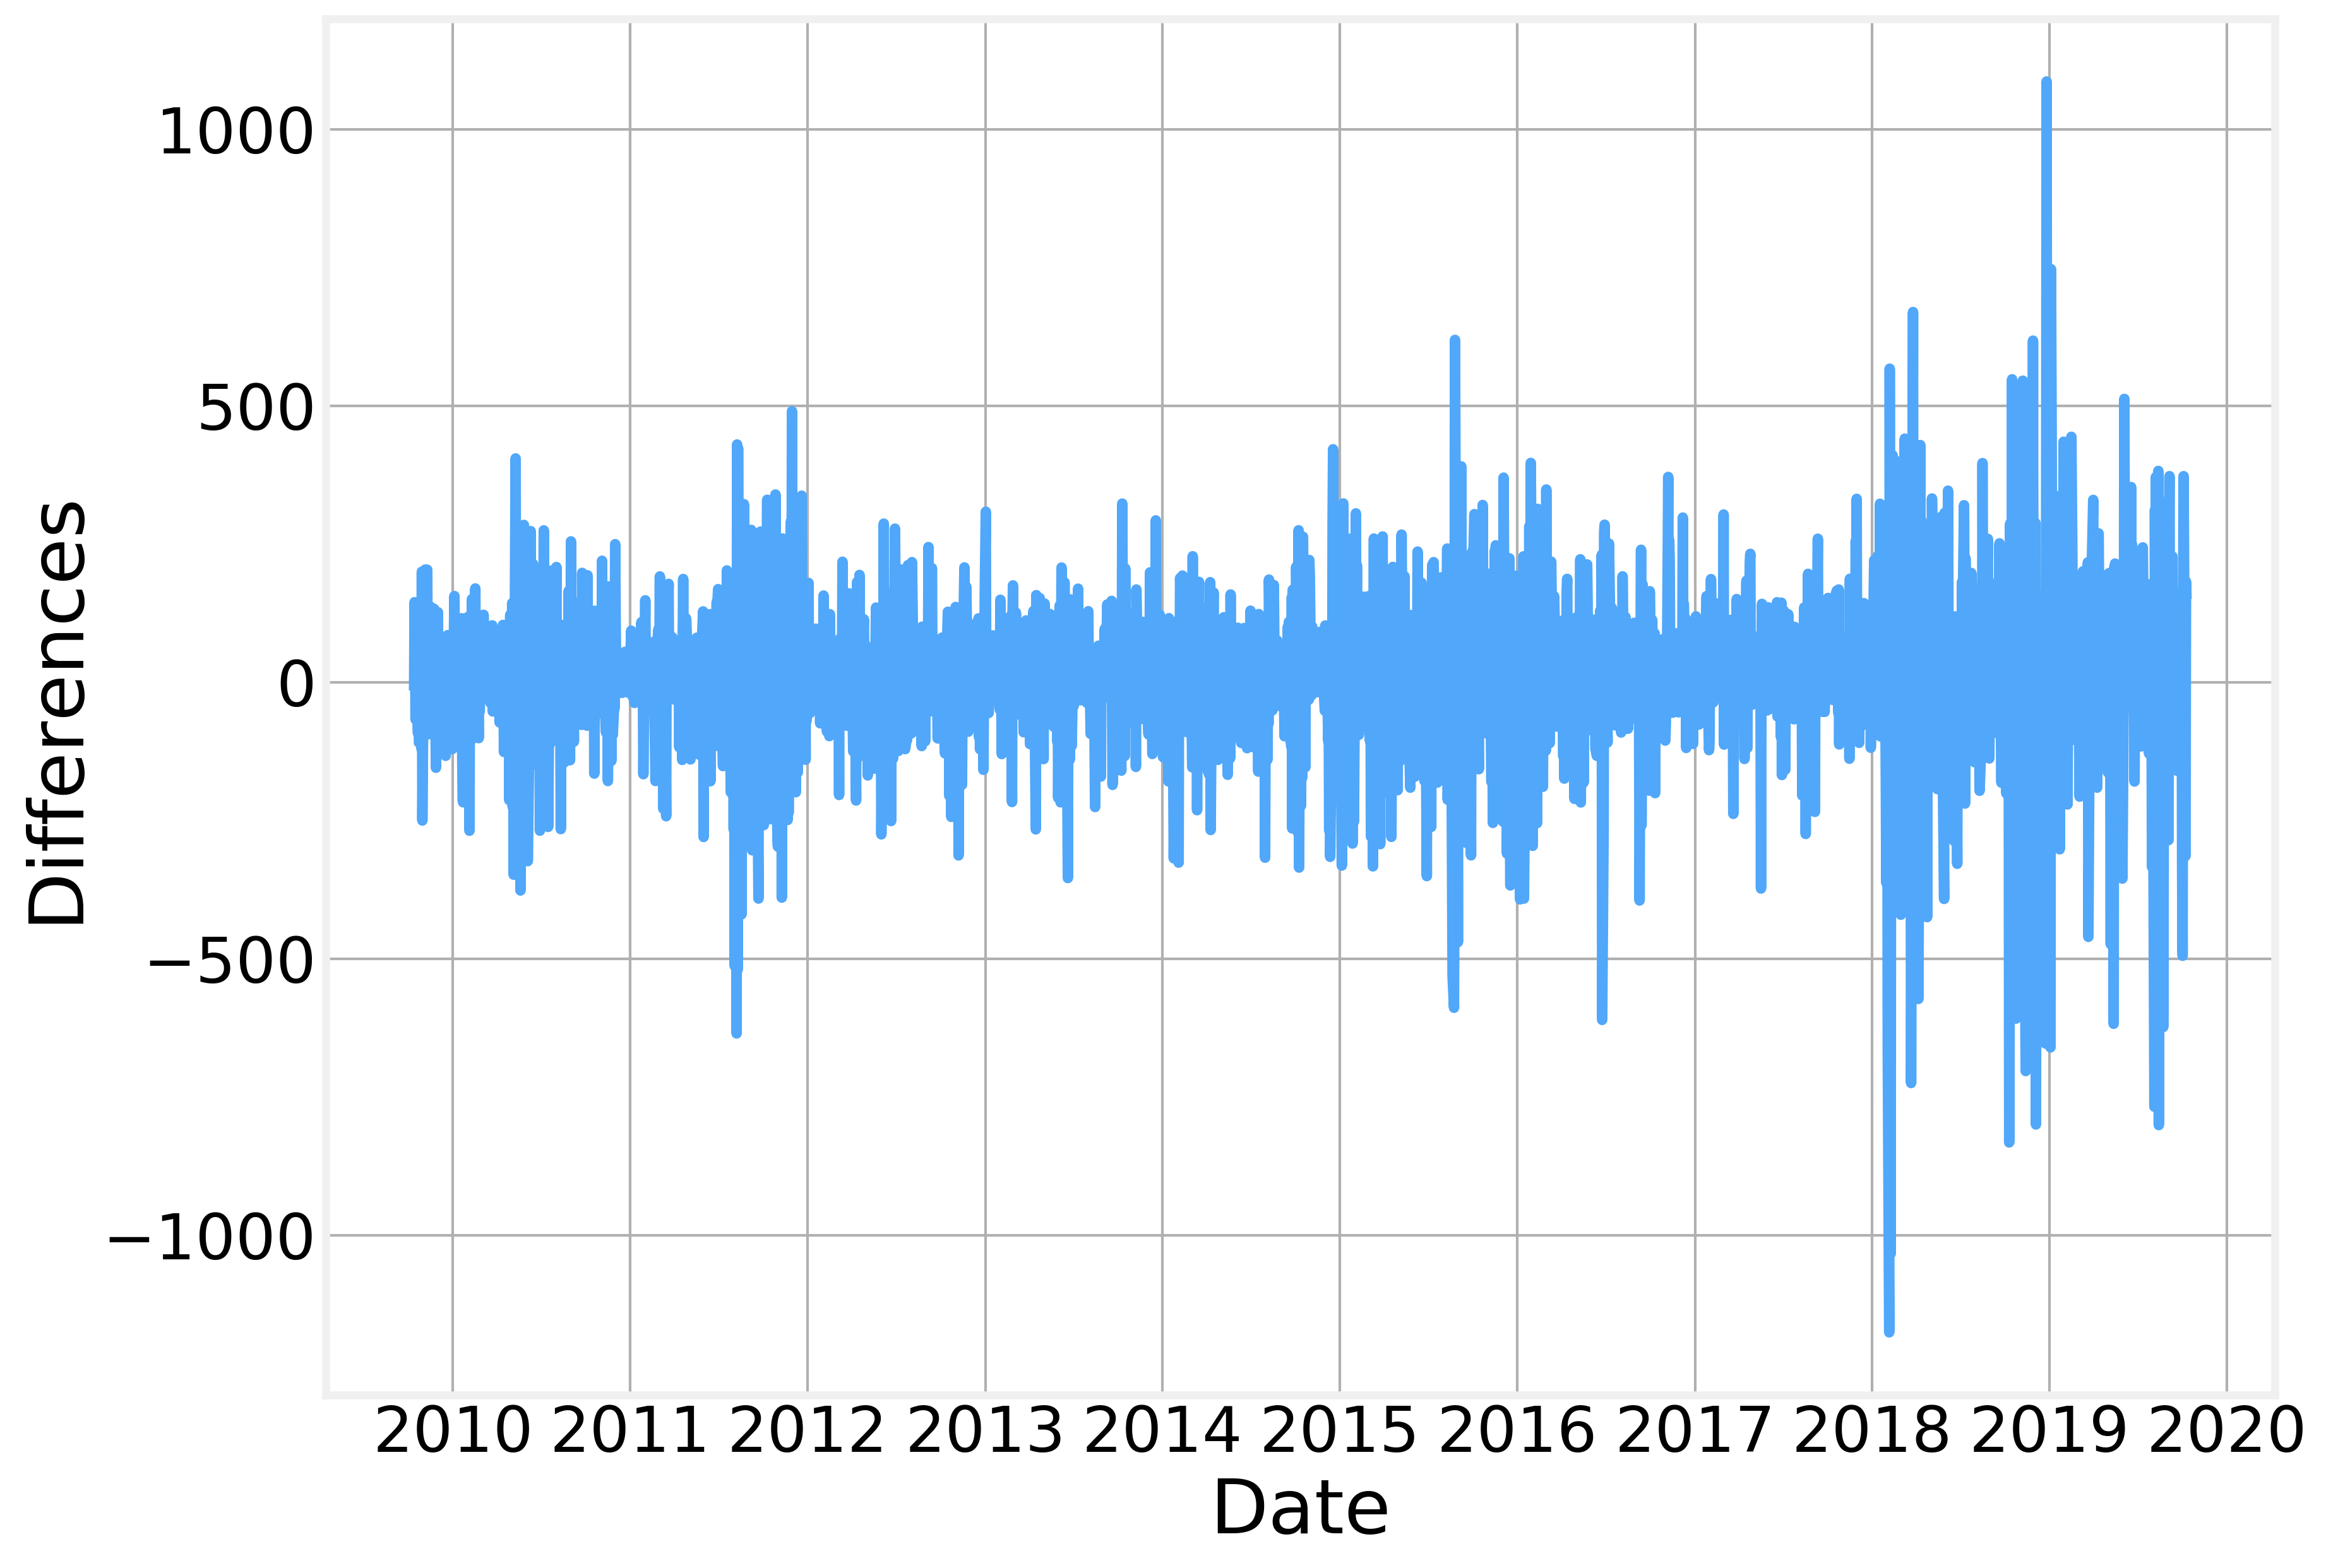

In [7]:
plt.plot(DJIA['DATE'].iloc[1:], differences[1:])
plt.xlabel('Date')
plt.ylabel('Differences')

To recover the original data we must simply integrate the differenced points. Note that in the differentiate function we explicitly included the first value of the original data in the output to make this possible.

In [8]:
def integrate(values, d=1):
    x = np.cumsum(values)
    
    if d == 1:
        return x
    else:
        return integrate(x, d-1)

In [9]:
rebuilt = integrate(differences)

And a quick check to make sure we recover the same values

In [10]:
np.mean(rebuilt-values)

0.0

## Windowing

We also often want to calculate running values of some quantity. This requires the use of windowing functions that return the proper element at each step. 

In [11]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order+1):
        running.append(x[i:i+order])
        
    return np.array(running)

And a simple example

In [12]:
values = np.arange(11)

In [13]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
rolling(values, 6)

array([[ 0,  1,  2,  3,  4,  5],
       [ 1,  2,  3,  4,  5,  6],
       [ 2,  3,  4,  5,  6,  7],
       [ 3,  4,  5,  6,  7,  8],
       [ 4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10]])

Since we return a numpy array with all the individual windows, this also provides us with a simple way to take running averages by chaining methods

In [15]:
rolling(values, 2)

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10]])

In [16]:
rolling(values, 2).mean(axis=1)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

Or the running maximum, etc.

In [17]:
rolling(values, 5).max(axis=1)

array([ 4,  5,  6,  7,  8,  9, 10])

## Exponential Smoothing

Another form of smoothing a noise time series is called exponential smoothing. This is equivalent to an exponentially weighted running average where past values get exponentially reduced.

In [18]:
def ES(values, alpha= 0.05):
    N = len(values)
    S = [values[0]*alpha]
    
    for i in range(1, N):
        S.append(alpha*values[i]+(1-alpha)*S[-1])
        
    return np.array(S)

As we can see with a few quick examples, the smaller the value of alpha the smoother (less noisy) the result

In [19]:
smooth = []
smooth.append(ES(differences[1:], 0.01))
smooth.append(ES(differences[1:], 0.1))
smooth.append(ES(differences[1:], 0.5))

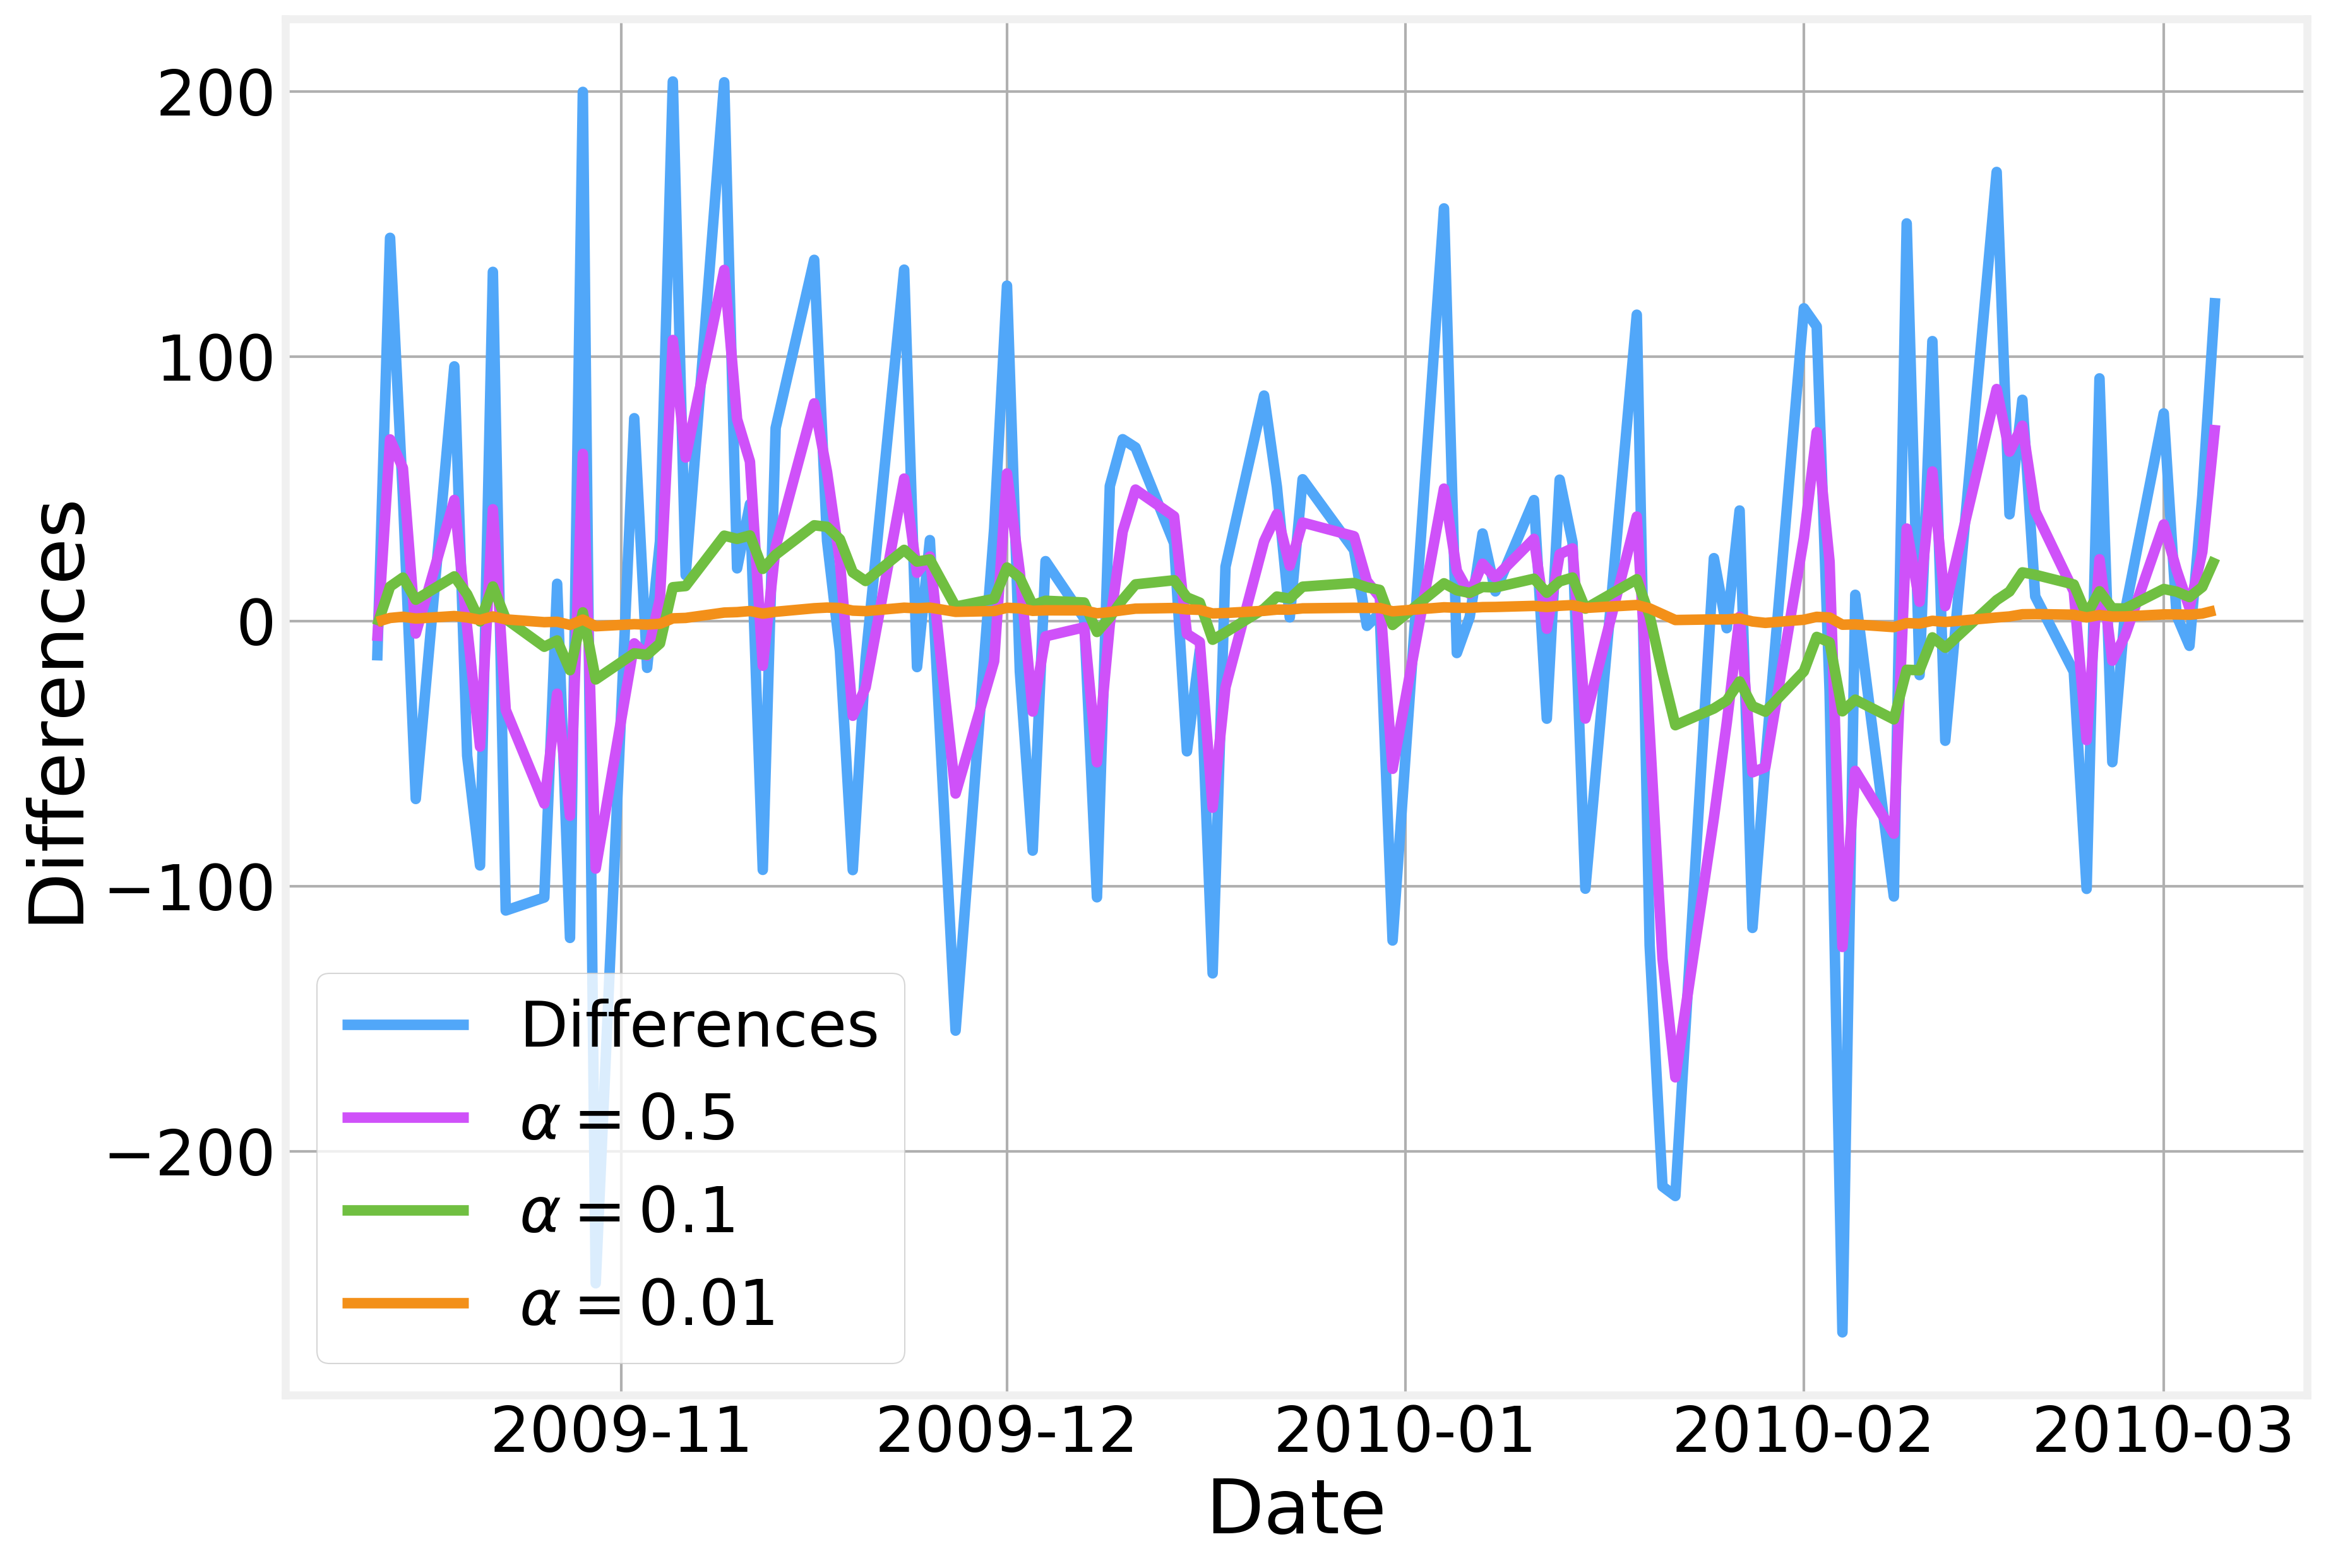

In [20]:
plt.plot(DJIA['DATE'].iloc[1:100], differences[1:100], label='Differences')
plt.plot(DJIA['DATE'].iloc[1:100], smooth[2][:99], label=r'$\alpha=0.5$')
plt.plot(DJIA['DATE'].iloc[1:100], smooth[1][:99], label=r'$\alpha=0.1$')
plt.plot(DJIA['DATE'].iloc[1:100], smooth[0][:99], label=r'$\alpha=0.01$')
plt.xlabel('Date')
plt.ylabel('Differences')
plt.legend()

## Missing Data

Unfortunately, data is not always clean or complete, forcing us to deal with missing data points. Here we illustrate several approaches to inputating missing values. We start by generating a dataset with missing values

In [21]:
x = np.linspace(-np.pi, np.pi, 100)
y = np.cos(x)
y_missing = y.copy()
y_missing[40:55] = np.nan

This is simply a cosine function with a few missing values at the peak.

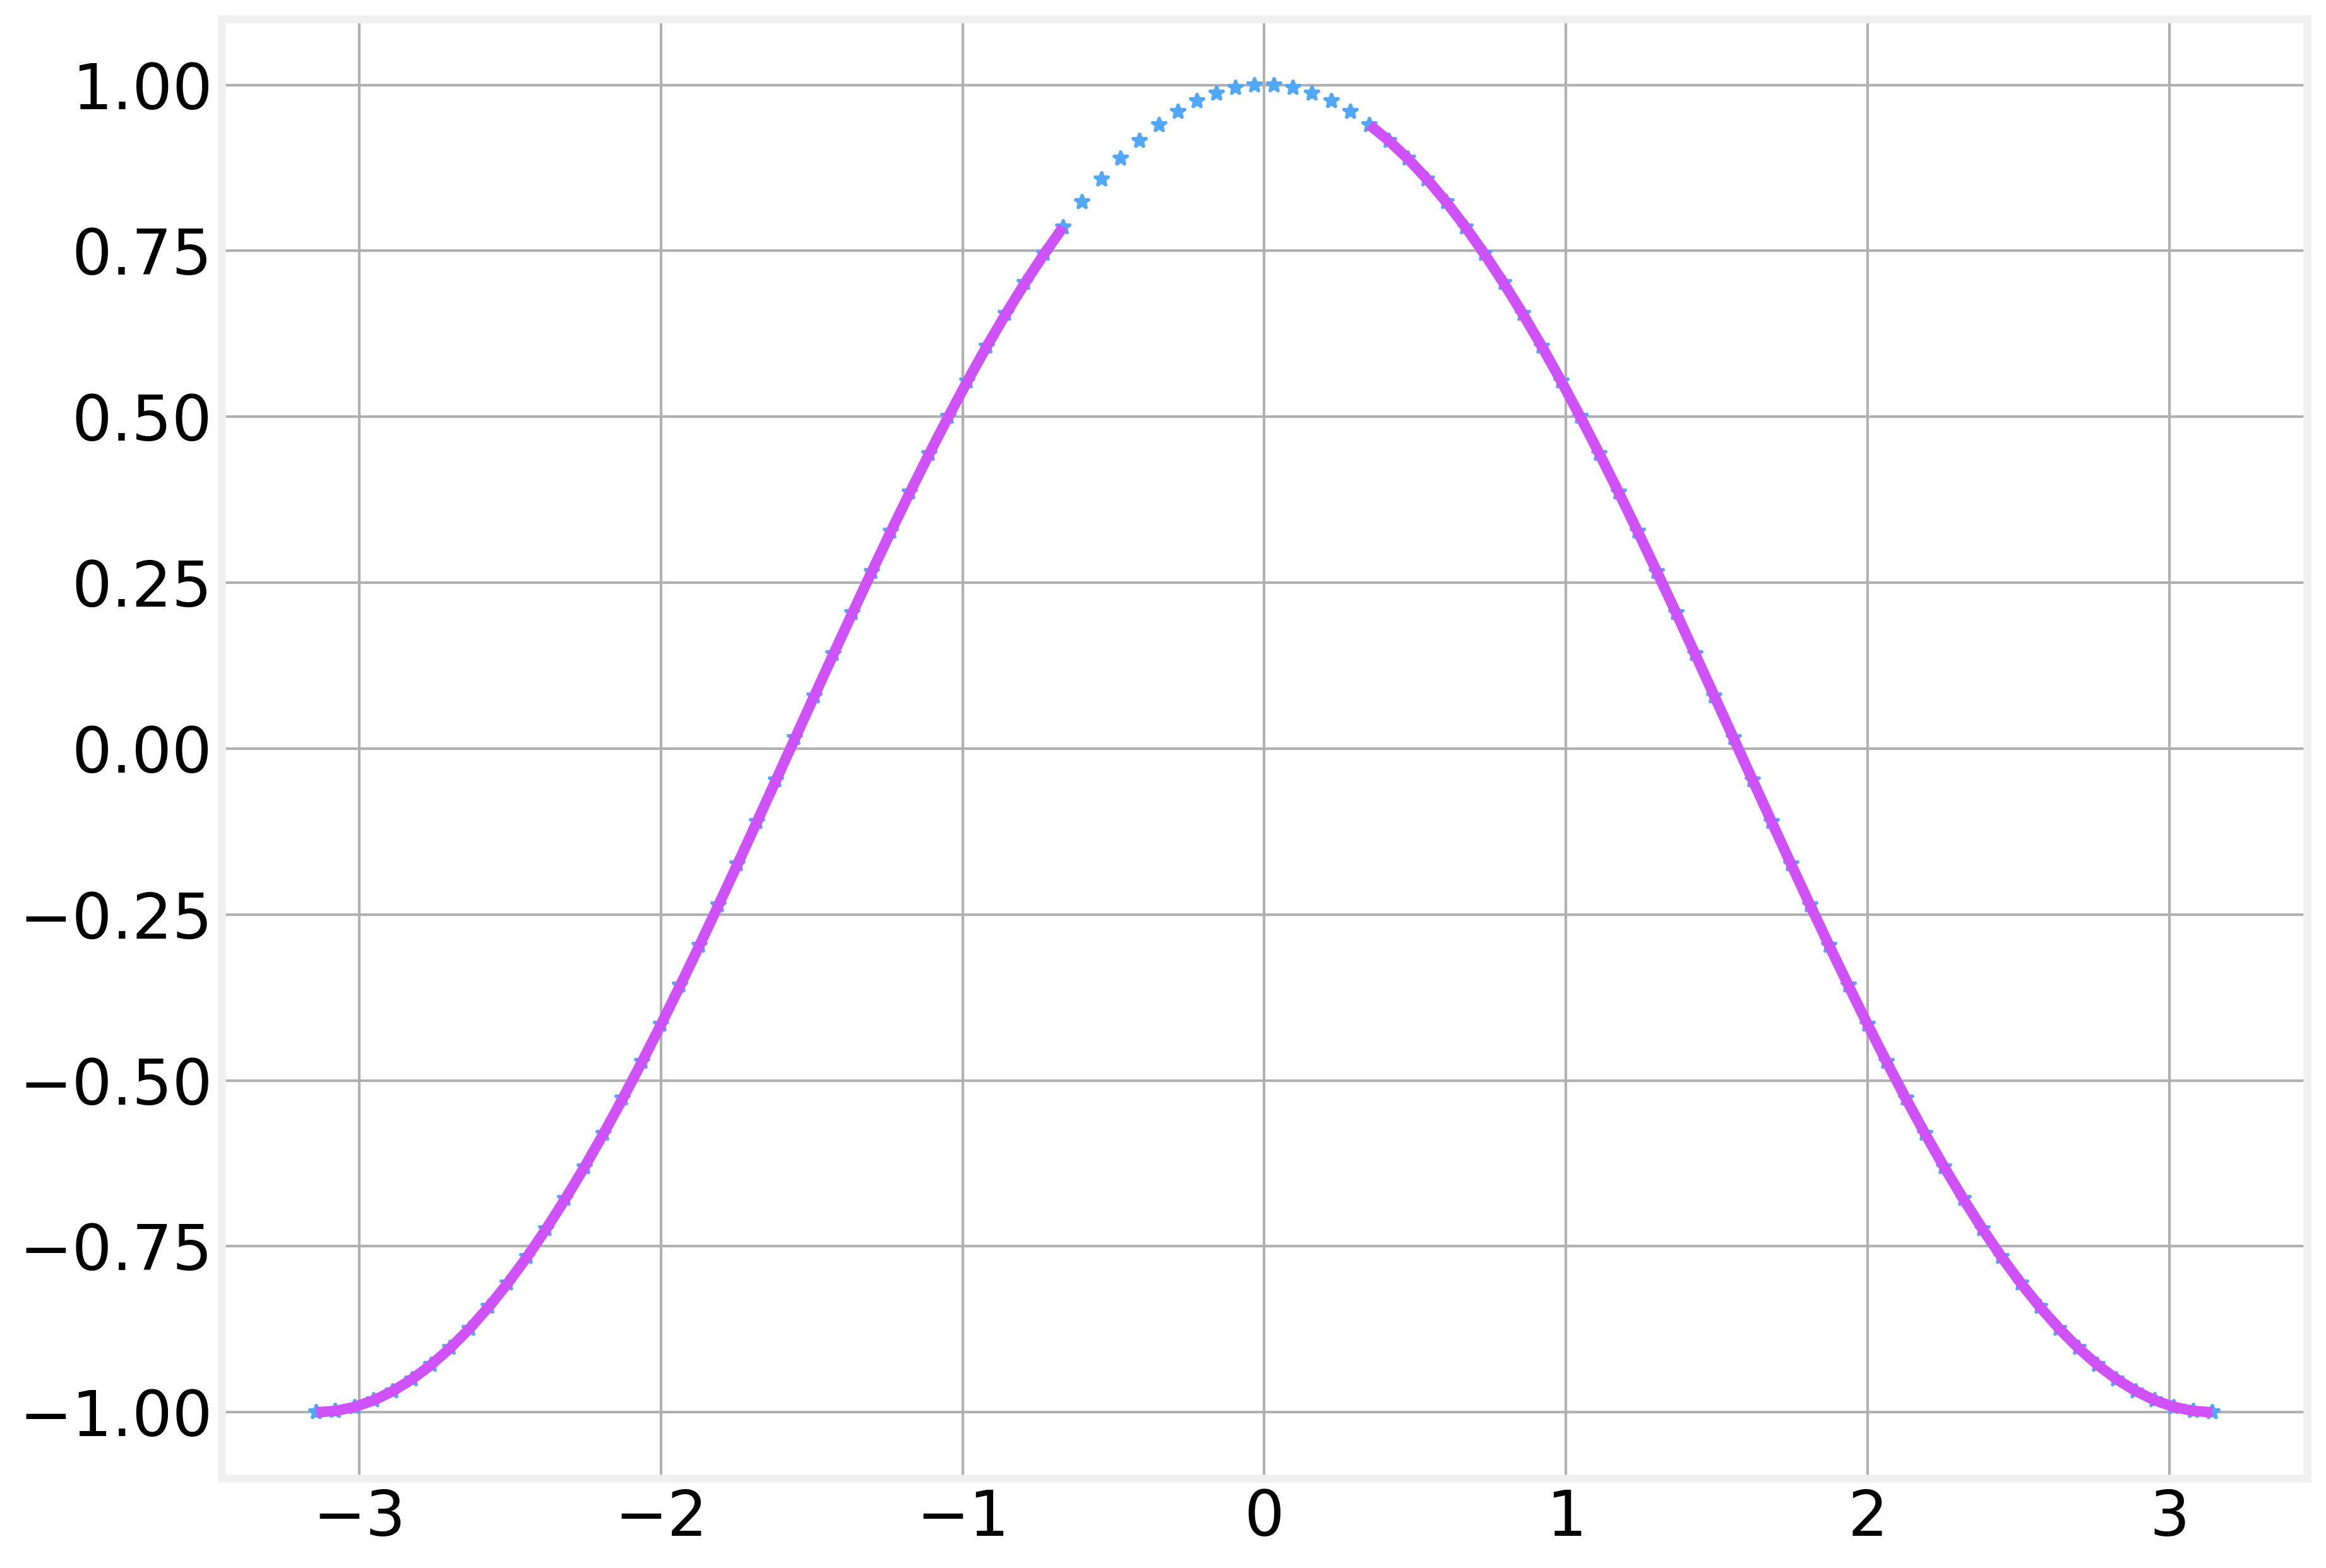

In [22]:
plt.plot(x, y, '*')
plt.plot(x, y_missing)

Perhaps the most common strategy is to simply keep the last known 'good' value and use it to fill in the missing data points. This approach is unable to deal with missing values at the beginning of the dataset.

In [23]:
def ffill(y):
    y0 = y.copy()
    N = len(y0)
    
    current = None
    for i in range(1, N):
        if np.isnan(y0[i]):
            y0[i] = current
        else:
            current = y0[i]
    
    return y0

Naturally, the opposite approach is also common where we use the next good value. In this way we can easly handling missing the initial values but can do nothing about any values lost at the end of the time series

In [24]:
def bfill(y):
    y0 = y.copy()
    N = len(y0)
    
    current = None
    for i in range(N-1, 0, -1):
        if np.isnan(y0[i]):
            y0[i] = current
        else:
            current = y0[i]
    
    return y0

Back-fill and Forward-fill are simple but powerful approachs to deal with missing data. However, we often want to be more careful about wchich value we inpute. One common approach is to interpolate between the previous and the next value and connecting them with a straight line. 

In [25]:
def interpolate(y):
    y0 = y.copy()
    N = len(y0)
    
    pos = 0
    while pos < N:
        if np.isnan(y0[pos]):
            count = 0
            
            while np.isnan(y0[pos+count]):
                count += 1
            
            current = y0[pos-1]
            future = y0[pos+count]
            slope = (future-current)/count
            
            y0[pos:pos+count] = current + np.arange(1, count+1)*slope
            
            pos += count
        else:
            pos += 1
            
    return y0

Data inputation (the calculation of the expected missing values) is a large subfield of statistics with a wide range of techniques and approaches. See https://en.wikipedia.org/wiki/Imputation_(statistics) for some pointer to more sophisticated methodologies

In [26]:
y_bfill = bfill(y_missing)
y_ffill = ffill(y_missing)
y_inter = interpolate(y_missing)

And a quick plot to visualize the differences

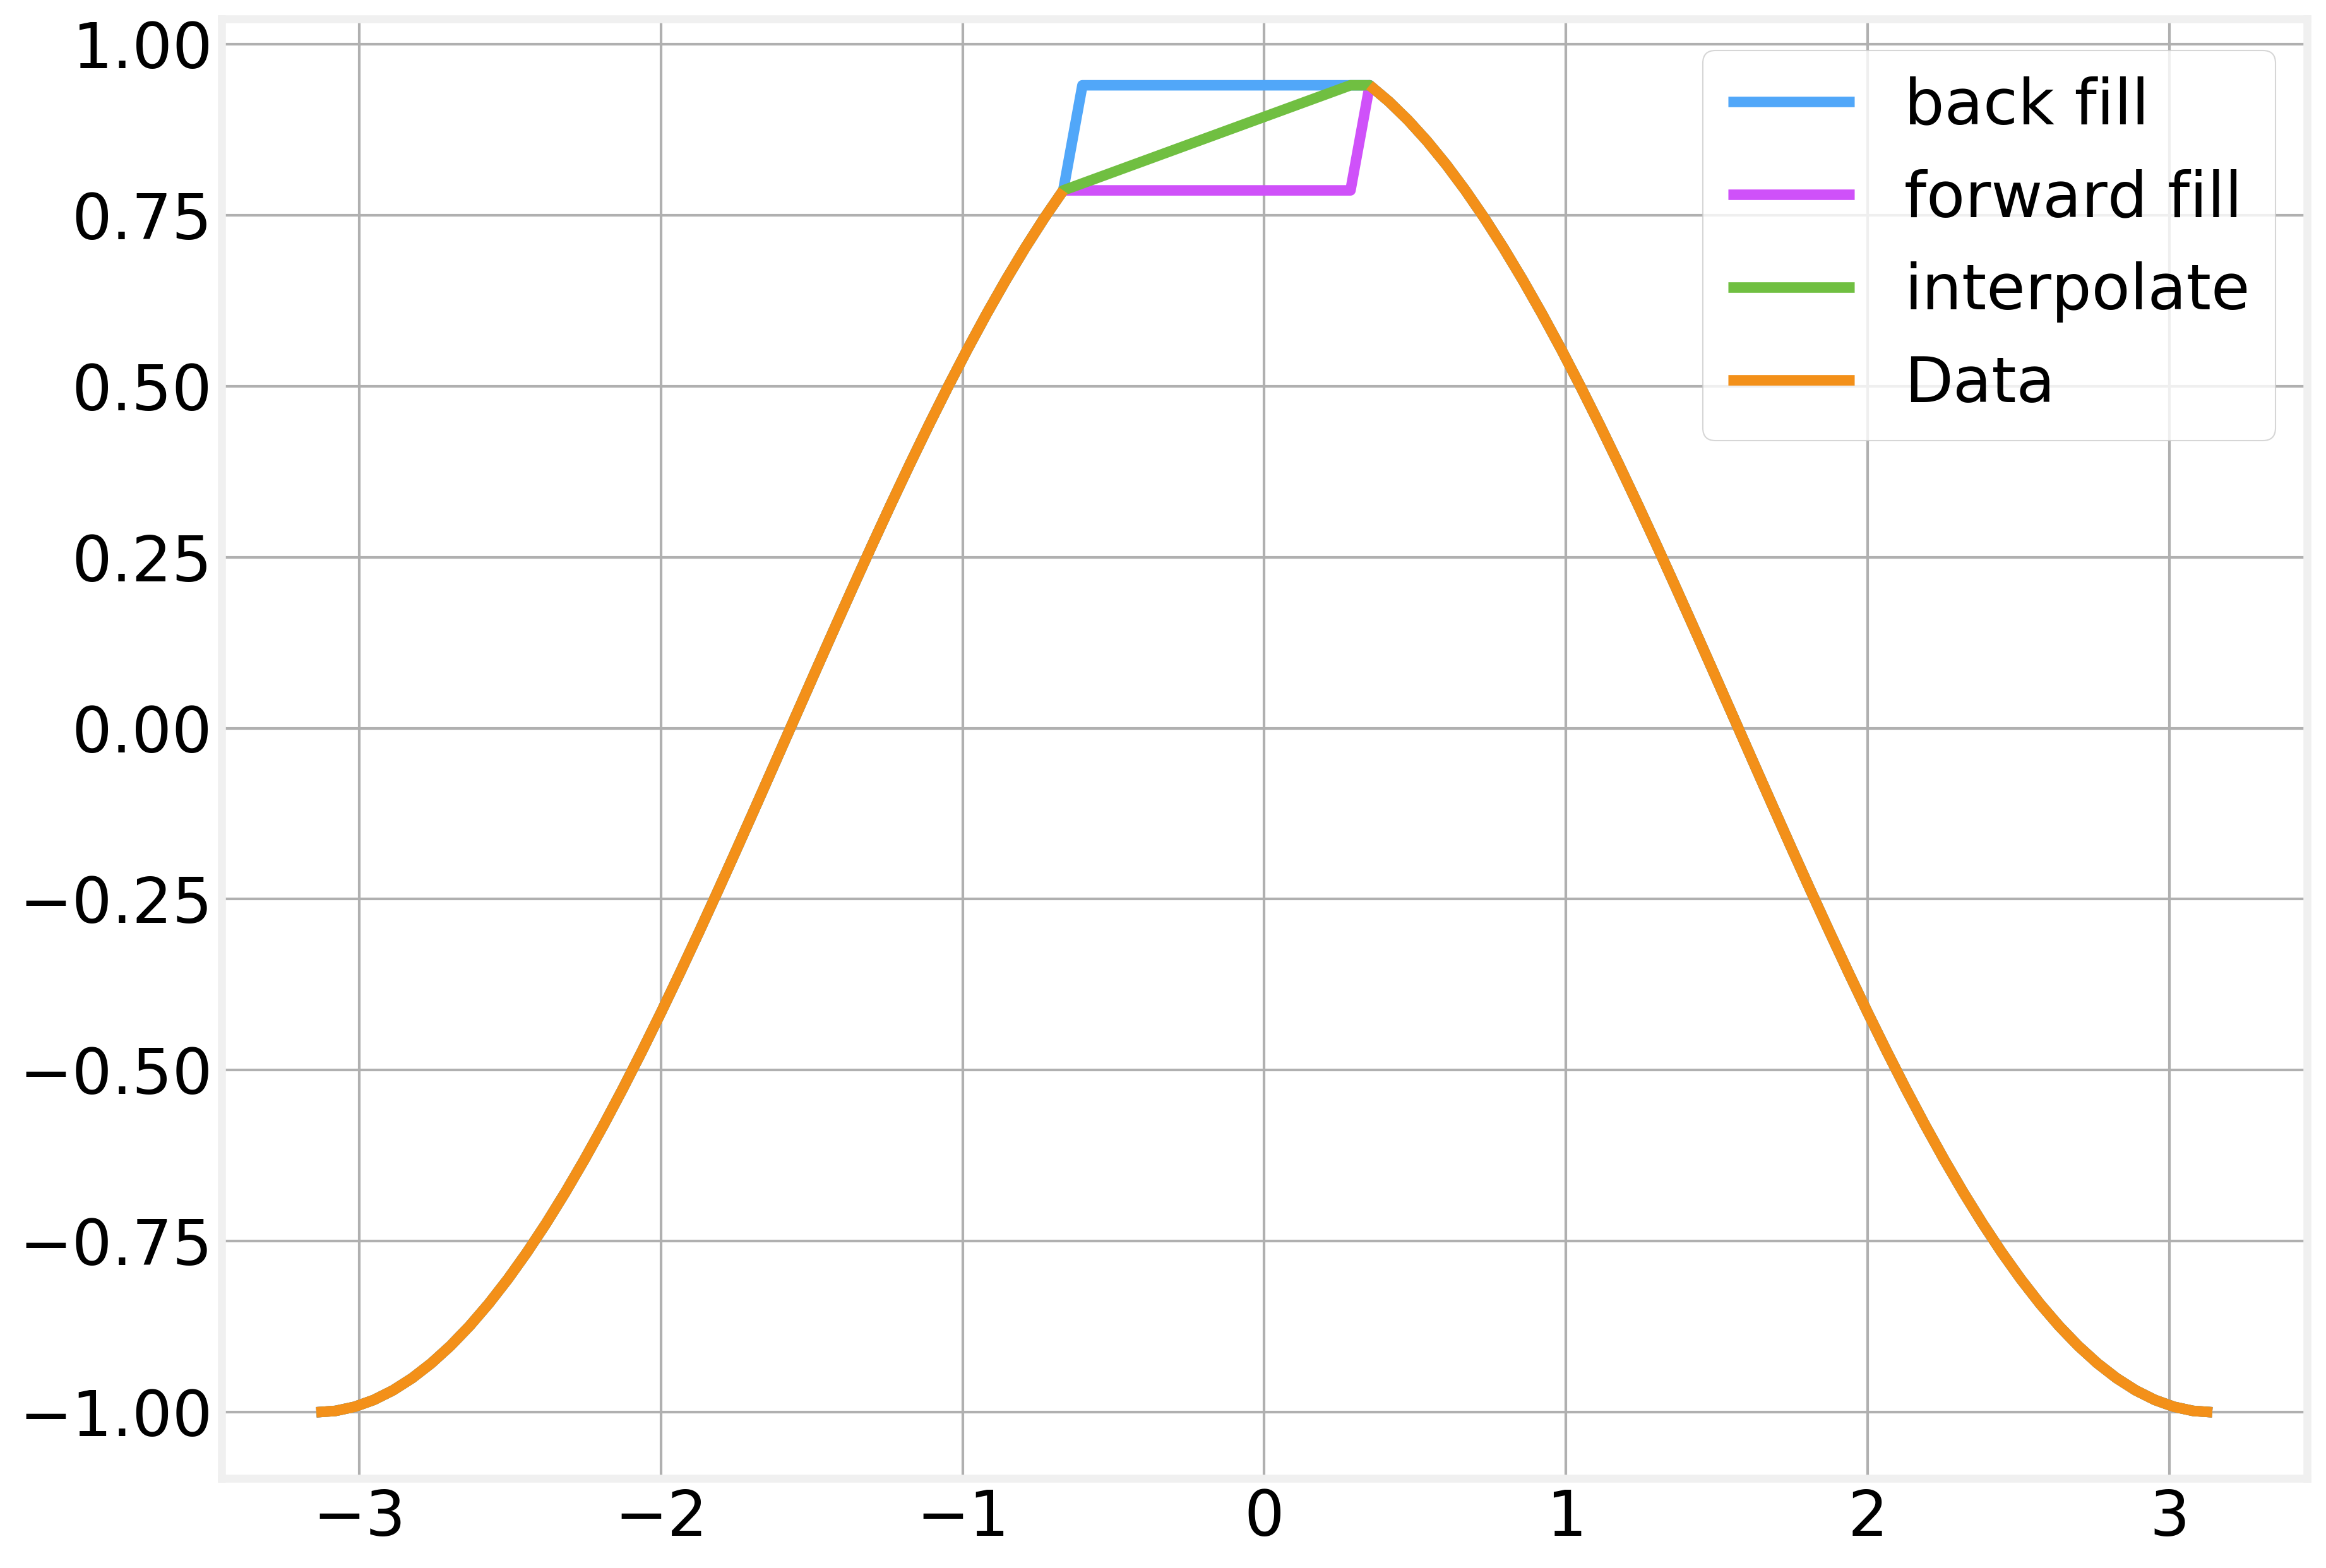

In [27]:
plt.plot(x, y_bfill, label='back fill')
plt.plot(x, y_ffill, label='forward fill')
plt.plot(x, y_inter, label='interpolate')
plt.plot(x, y_missing, label='Data')
plt.legend()

## Resampling

In many cases we also need to change the frequency at which we are operating. For example, our DJIA dataset has end of day values, but we might be interested in weekly or monthly data points. Resampling is a series of techniques designed to deal with this situation and is similar in spirit to the windowing techniques we saw above. The main difference is that instead of simply moving the window at a fixed step we have each window correspond to our period of interest.

In [28]:
mapping = DJIA['DATE'].dt.year
values = DJIA['DJIA'].values

In the simplest case we simply calculate what the correct window is for each data point and aggregate accordingly

In [29]:
def groupBy(values, mapping, func = None):
    agg = {}
    pos = {}
    
    for i in range(values.shape[0]):
        key = mapping.iloc[i]
        
        if key not in agg:
            agg[key] = []
        
        pos[key] = i
        
        if not np.isnan(values[i]):
            agg[key].append(values[i])
        
    order = sorted(agg.keys())
    
    if func is not None:
        for key in agg:
            agg[key] = func(np.array(agg[key]).astype('float'))
            
    return agg, pos

Naturally this groupBy function is useful not only for resampling but also for wide range of statistical analysis. In addition to a mapping, we must also specify what aggregation function we want to use. Are we interested in the average value? the maximum? standard deviation?

In [30]:
agg, pos = groupBy(values, mapping, np.mean)

Here we simply calculted the mean value for each year

In [31]:
agg

{2009: 10232.334385964914,
 2010: 10668.589087301589,
 2011: 11957.570238095239,
 2012: 12965.28744,
 2013: 15009.523492063492,
 2014: 16777.690912698414,
 2015: 17587.029166666664,
 2016: 17927.107341269842,
 2017: 21750.20374501992,
 2018: 25046.85734939759,
 2019: 26000.832040816327}

As our groupBy function also returns the index positions of the last time each bin was seen we can easily compare the original data with the resampled one.

In [32]:
aggregated = []

for key in pos:
    aggregated.append([pos[key], agg[key]])

aggregated = np.array(aggregated)

In [33]:
aggregated

array([[   56.        , 10232.33438596],
       [  308.        , 10668.5890873 ],
       [  560.        , 11957.5702381 ],
       [  810.        , 12965.28744   ],
       [ 1062.        , 15009.52349206],
       [ 1314.        , 16777.6909127 ],
       [ 1566.        , 17587.02916667],
       [ 1818.        , 17927.10734127],
       [ 2069.        , 21750.20374502],
       [ 2318.        , 25046.8573494 ],
       [ 2514.        , 26000.83204082]])

Text(0.5, 0, 'Date')

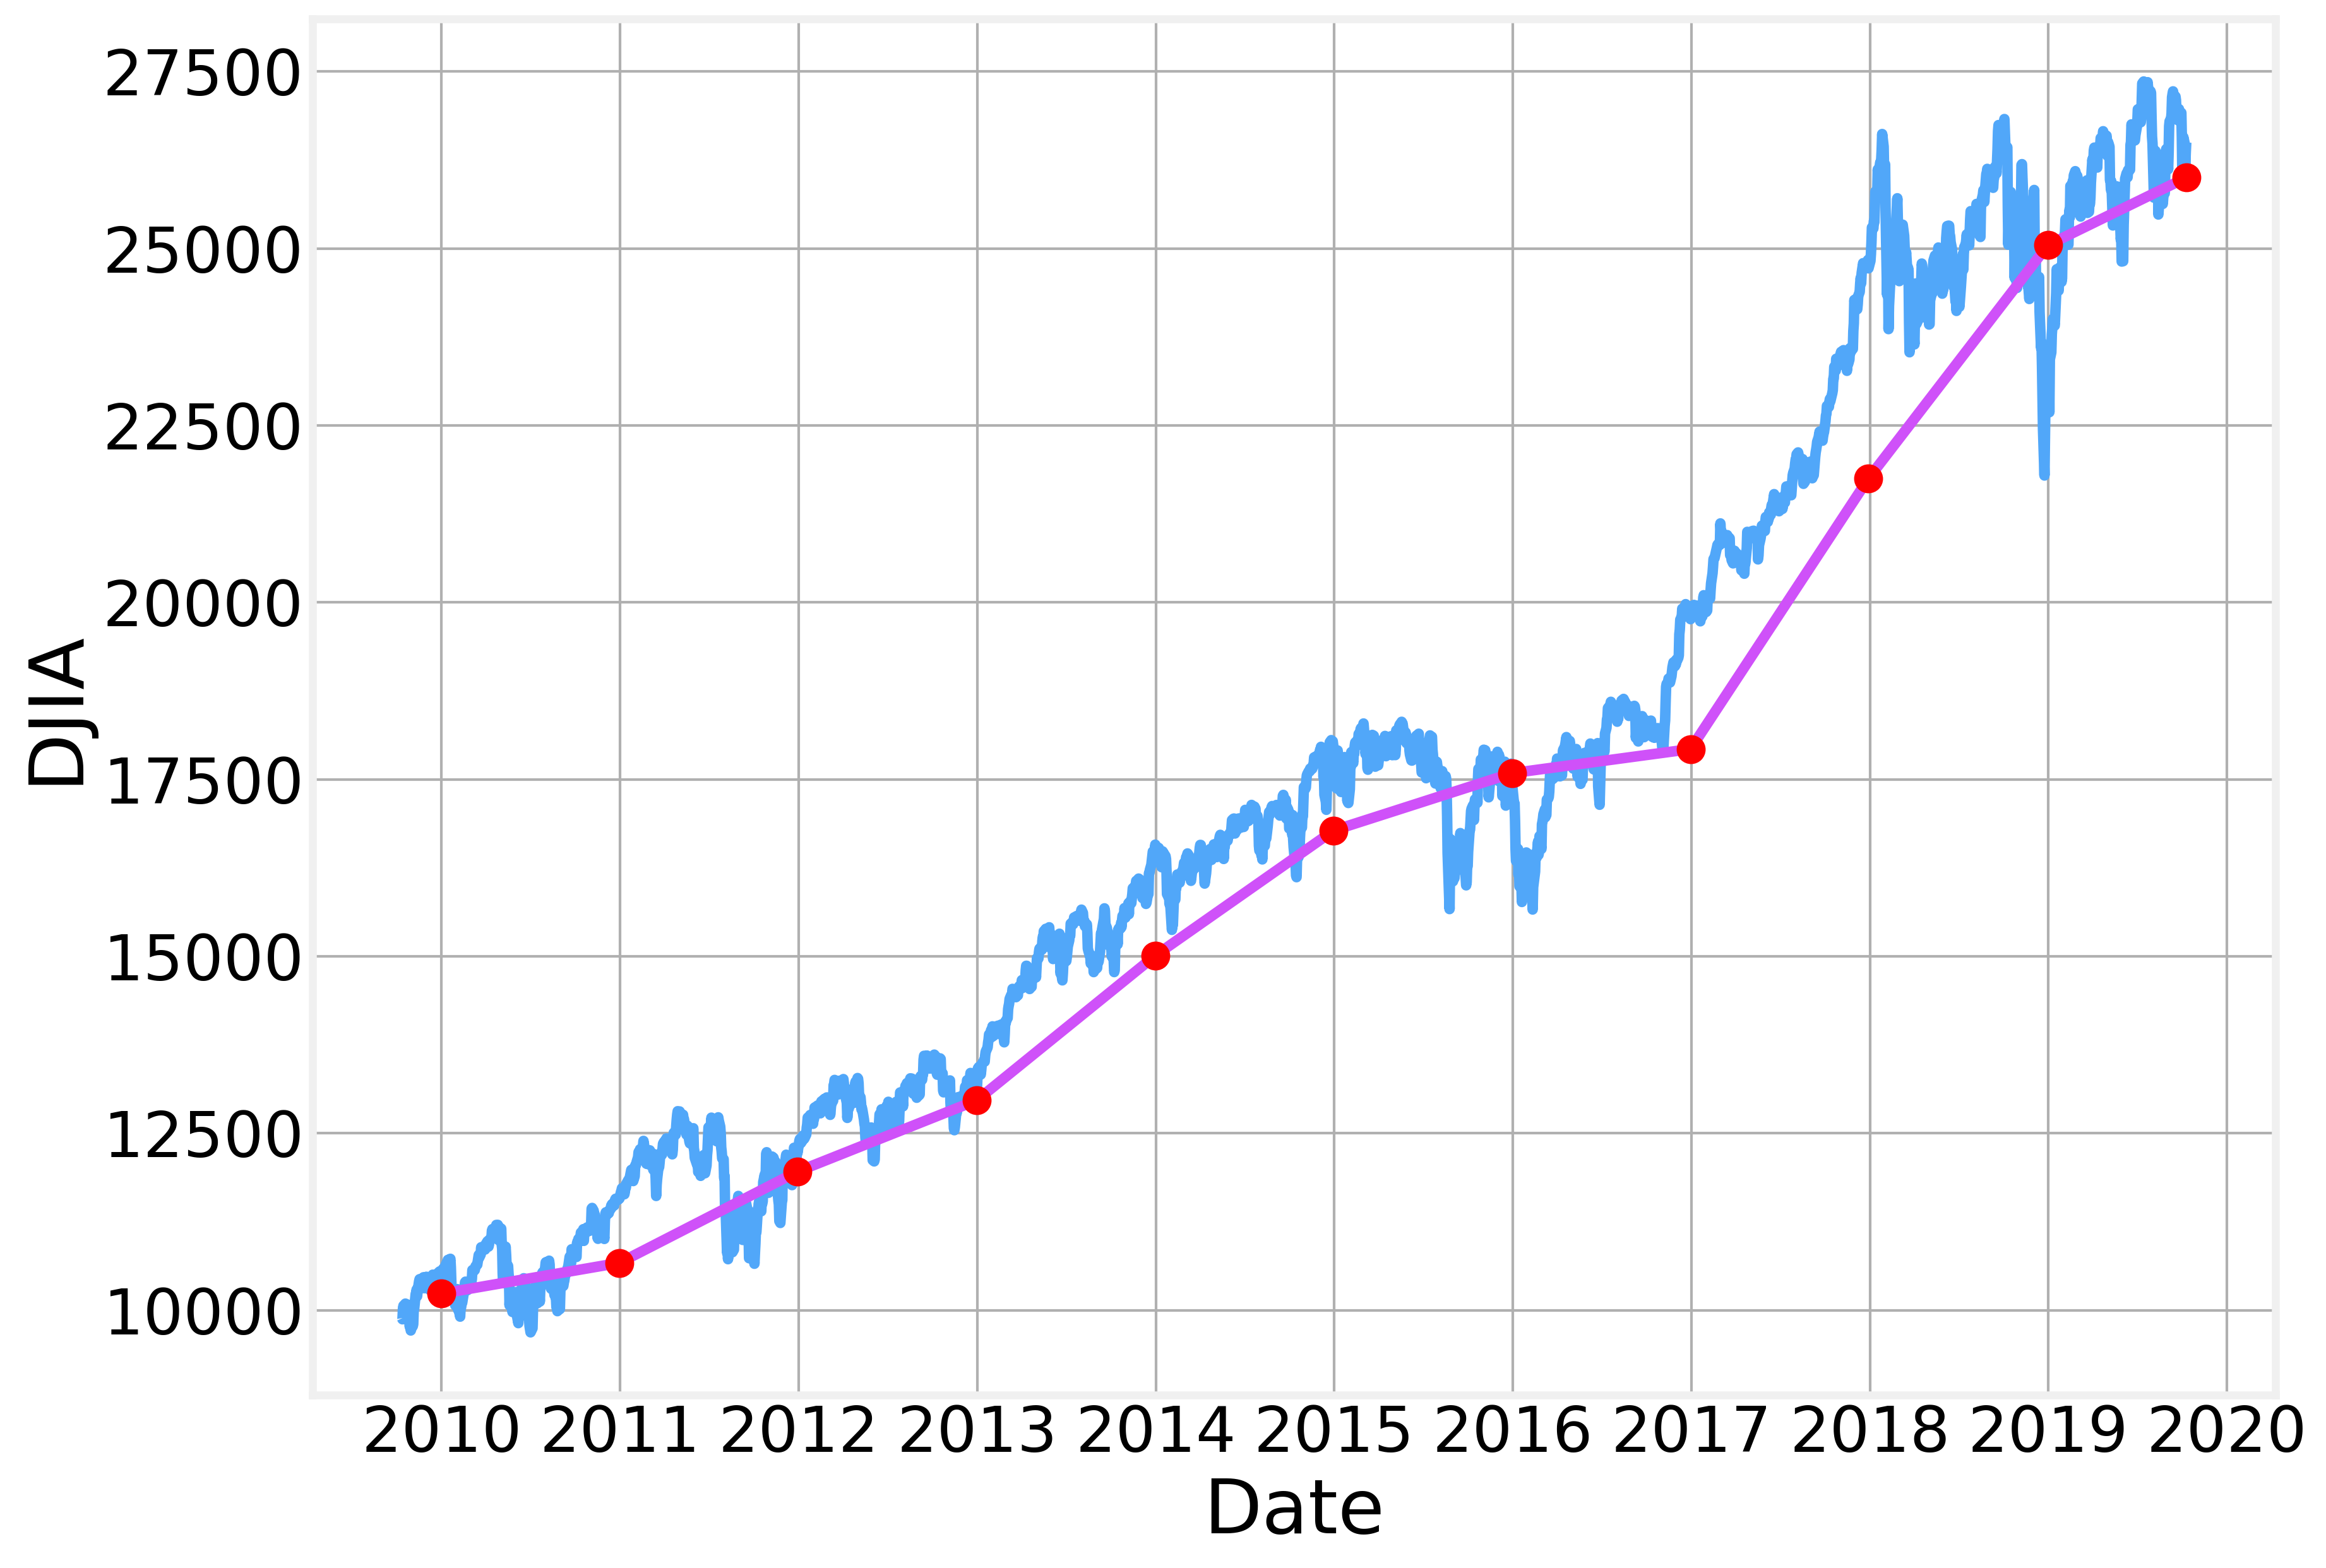

In [34]:
plt.plot(DJIA['DATE'], DJIA['DJIA'])
ax = plt.gca()
ax.plot(DJIA.set_index('DATE').index[aggregated.T[0].astype('int')], aggregated.T[1])
ax.plot(DJIA.set_index('DATE').index[aggregated.T[0].astype('int')], aggregated.T[1], 'ro', markersize=10,)
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

## Jackknife estimators

Finally, in many cases we want to estimate statistical quantities of time series. An obvious example might be to estimage the running average of a detrended series to verify if it is indeed sufficiently close to zero to be considered stationary. 

The JackKnife estimator allows us to obtain not only the expected value in question, but also a measure of it's variance. This is achieved by using a leave-one out approach to compute N estimates of our metric. From this population of estimage, we can then obtain the averages as the best possible estimate and the standard deviation as a measure of the error bars involved

In [35]:
def jackknife(x, func, variance = False):
    N = len(x)
    pos = np.arange(N)
    values = [func(x[pos != i]) for i in pos]
    jack = np.sum(values)/N
    
    if variance:
        values = [np.power(func(x[pos != i]) - jack, 2.0) for i in pos]
        var = (N-1)/N * np.sum(values)
        return jack, var
    else:
        return jack

In [36]:
x = np.random.normal(0, 2, 100)
print(x.std())
jackknife(x, np.std, True)

2.108653235313273


(2.1085064410133474, 0.016373127387276185)

With jackknife we obtain not only an estimate of the value but also a measure of the error

## Bootstrapping

Another common technique to estimate statistical properties is known as bootstrapping and is closely related to the Jackknife. In this approach we simply sample (with replacement) from the original population to get a measure of how much variability can be expected

In [37]:
def bootstrapping(x, n_samples, func=np.mean):
    y = x.copy()
    N = len(y)
    population = []
    
    for i in range(n_samples):
        population.append(func(np.random.choice(y, N, replace=True)))
        
    return np.array(population)

We can easily generate a histogram over all the the bootstrapped samples

In [38]:
def histogram(values, n_bins=100):
    xmax = values.max()
    xmin = values.min()
    delta  = (xmax-xmin)/n_bins
    
    counts = np.zeros(n_bins+1, dtype='int')
    
    for value in values:
        val_bin = np.around((value-xmin)/delta).astype('int')
        counts[val_bin] += 1.0
    
    bins = xmin+delta*np.arange(n_bins+1)
    
    return bins, counts/values.shape[0]

In [39]:
x = np.random.normal(0, 2, size=100)

In [40]:
boot = bootstrapping(x, 1000)

In [41]:
x.mean()

0.029764592021104912

In [42]:
x.std()

2.0767480340972737

In [43]:
bins, counts = histogram(boot)

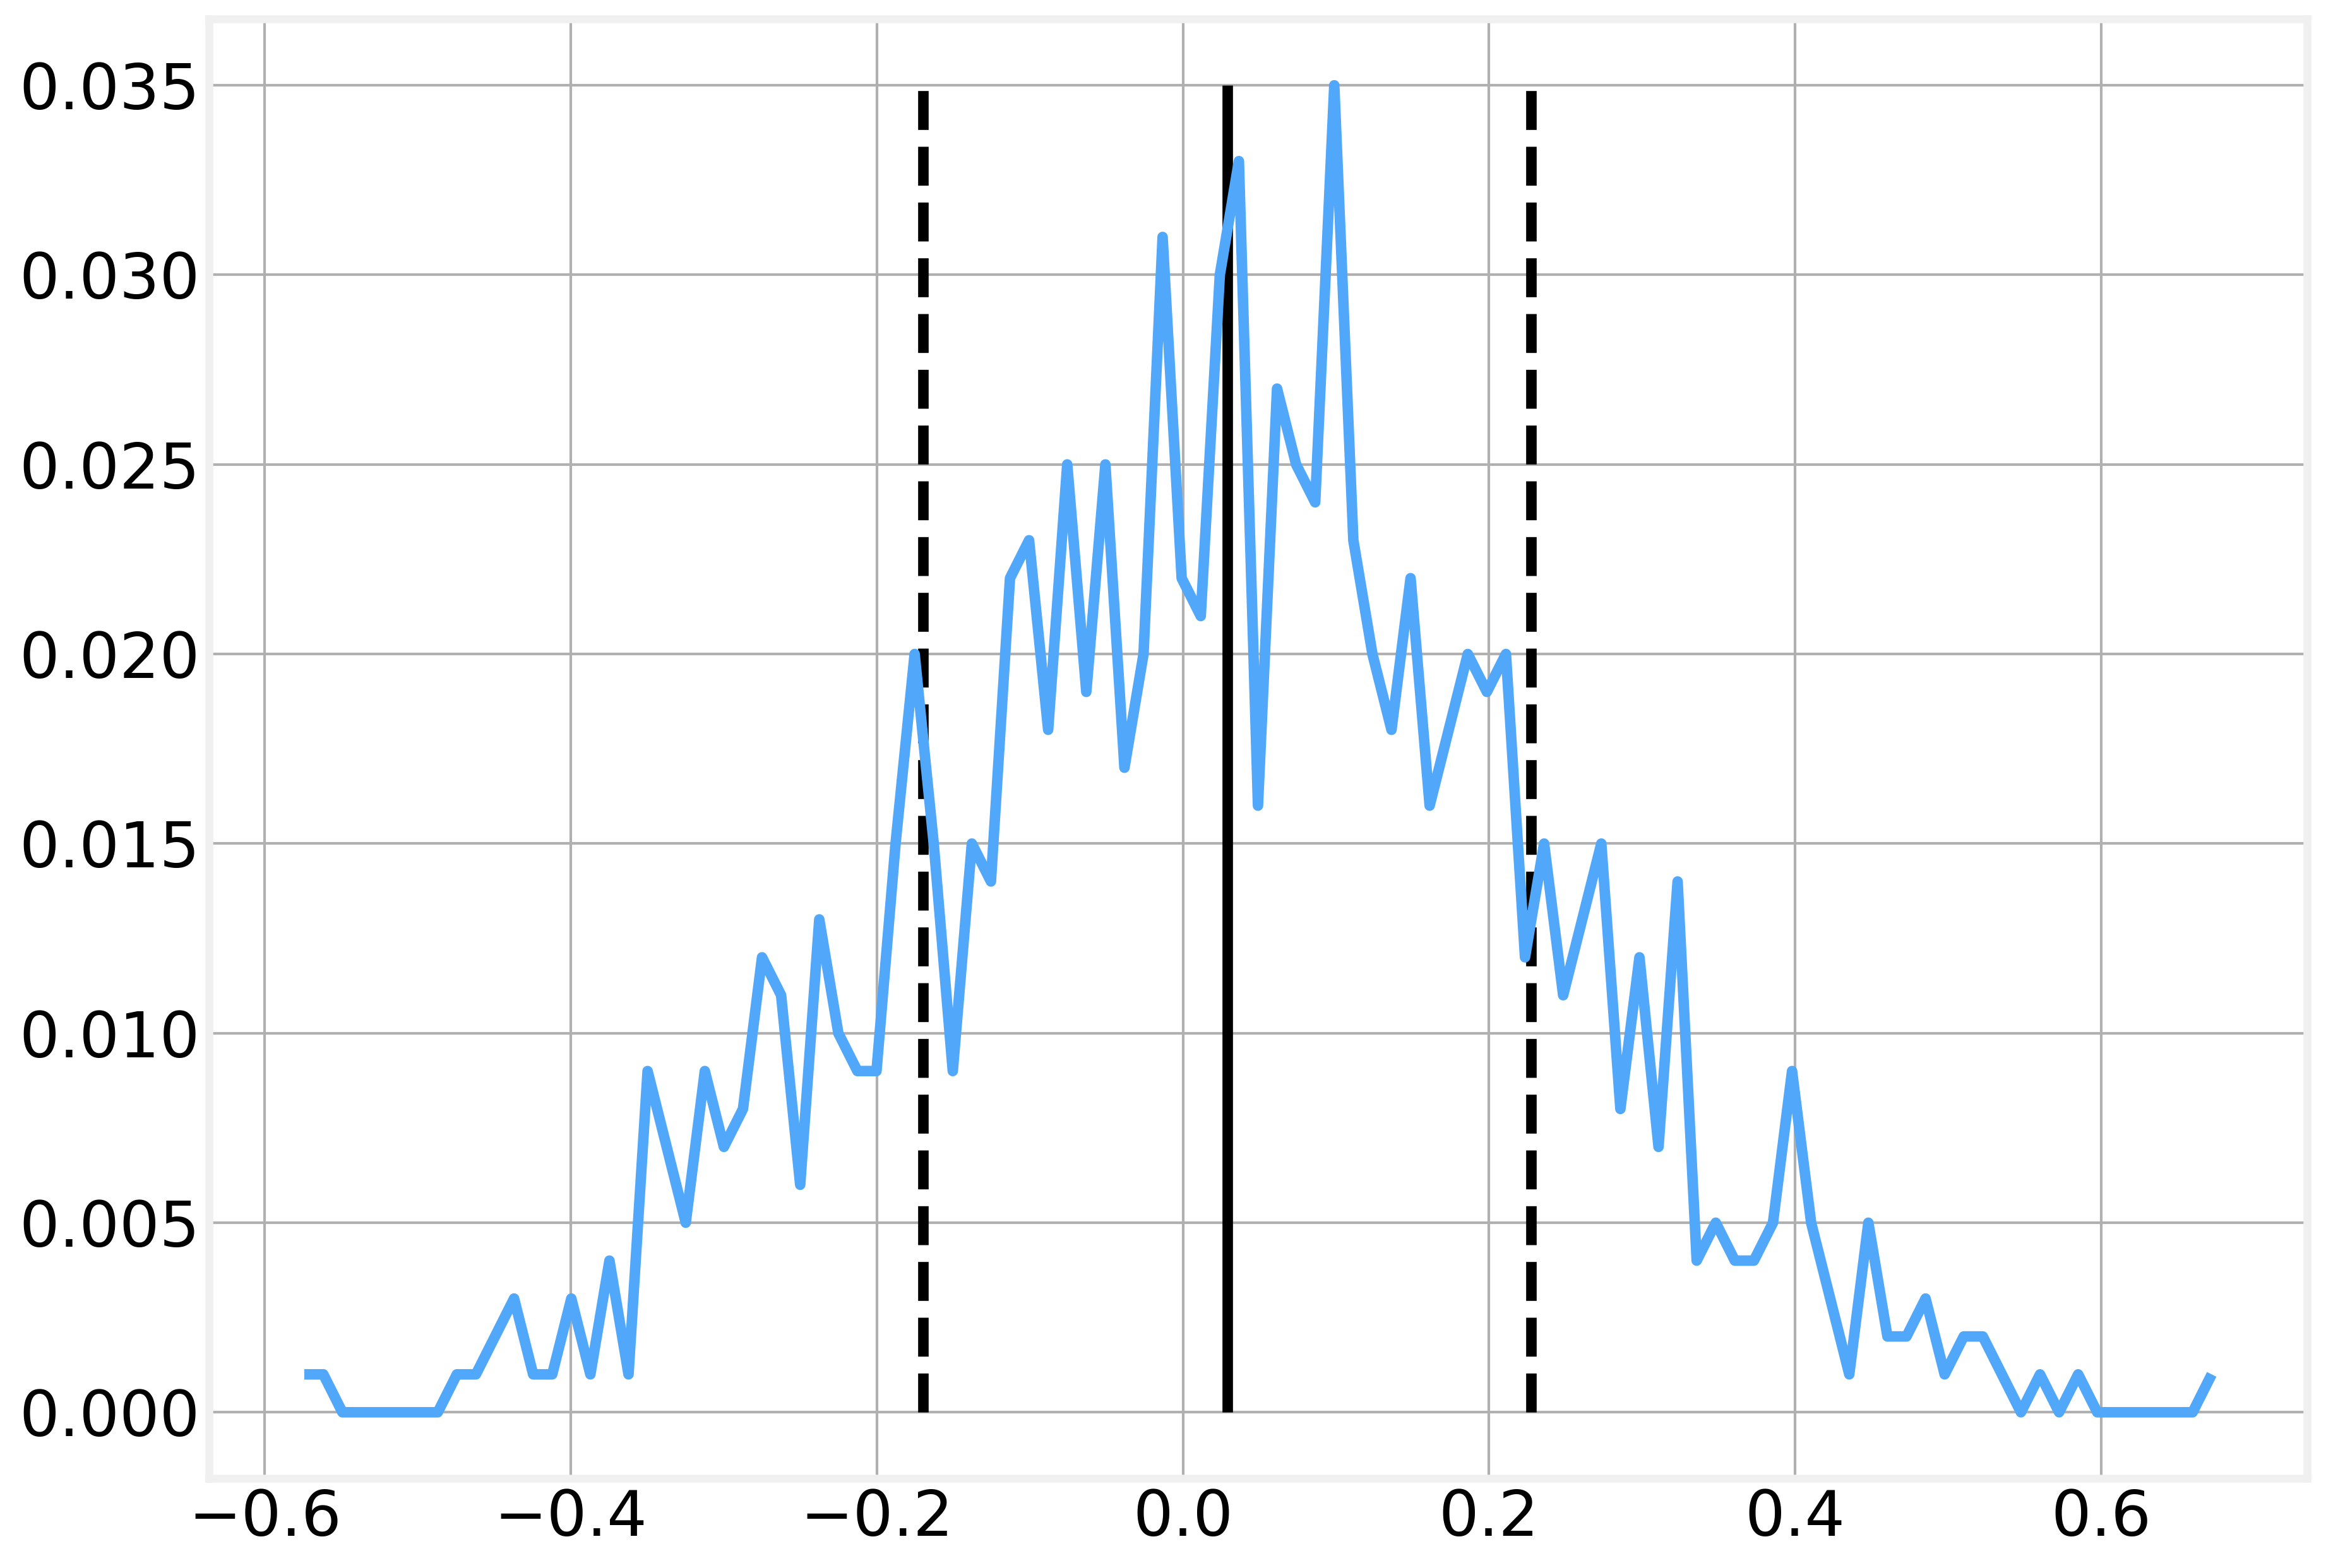

In [44]:
plt.plot(bins, counts)
plt.vlines(x=boot.mean(), ymin=0, ymax=counts.max(), label='mean')
plt.vlines(x=boot.mean()+boot.std(), ymin=0, ymax=counts.max(), label='std', linestyles='--')
plt.vlines(x=boot.mean()-boot.std(), ymin=0, ymax=counts.max(), label='std', linestyles='--')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>